In [1]:
from __future__ import division
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Input, Lambda
import keras.backend as K

import matplotlib.pyplot as plt
import scipy.misc
import os

%matplotlib inline

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


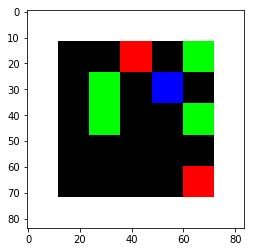

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False, size=5)

This is the game we'll be working on. The player can move the blue square up, down, left or right. The point of the game is to get to the green square (+1 reward) and avoid the red square (-1 reward). Blocks are randomized

Original shape: (84, 84, 3)
Processed shape: (84, 84, 3)


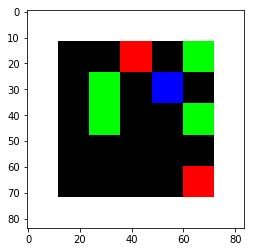

In [3]:
def process_state(state):
    """ This processes the state and converts to black & white. This will help speed up learning
        as the number of parameters will be reduced.
    """
    return state

plt.imshow(process_state(env.state))

print("Original shape: {}".format(env.state.shape))
print("Processed shape: {}".format(process_state(env.state).shape))

## Implementing the network

In [4]:
class Qnetwork():
    def __init__(self, final_layer_size):
        # The input image of the game is 84 x 84 x 3 (RGB) 
        self.inputs = Input(shape=[*process_state(env.state).shape], name="main_input")

        # There will be four layers of convolutions performed on the image input
        # A convolution take a portion of an input and matrix multiplies
        # a filter on the portion to get a new input (see below)
        self.model = Conv2D(
            filters=32,
            kernel_size=[8,8],
            strides=[4,4],
            activation="relu",
            padding="valid",
            name="conv1")(self.inputs)
        self.model = Conv2D(
            filters=64,
            kernel_size=[4,4],
            strides=[2,2],
            activation="relu",
            padding="valid",
            name="conv2")(self.model)
        self.model = Conv2D(
            filters=64,
            kernel_size=[3,3],
            strides=[1,1],
            activation="relu",
            padding="valid",
            name="conv3")(self.model)
        self.model = Conv2D(
            filters= final_layer_size,
            kernel_size=[7,7],
            strides=[1,1],
            activation="relu",
            padding="valid",
            name="conv4")(self.model)
        
        
        # We then separate the final convolution layer into an advantage and value
        # stream. The value function is how well off you are in a given state.
        # The advantage is the how much better off you are after making a particular
        # move. Q is the value function of a state after a given action.
        # Advantage(state, action) = Q(state, action) - Value(state)
        self.stream_AC = Lambda(lambda layer: layer[:,:,:,:final_layer_size // 2],name="advantage")(self.model)
        self.stream_VC = Lambda(lambda layer: layer[:,:,:,final_layer_size // 2:],name="value")(self.model)
        
        # We then flatten the advantage and value functions
        self.stream_AC = Flatten(name="advantage_flatten")(self.stream_AC)
        self.stream_VC = Flatten(name="value_flatten")(self.stream_VC)
        
        # We define weights for our advantage and value layers. We will train these
        # layers so the matmul will match the expected value and advantage from play
        self.Advantage = Dense(env.actions,name="advantage_final")(self.stream_AC)
        self.Value = Dense(1,name="value_final")(self.stream_VC)

        # To get the Q output, we need to add the value to the advantage.
        # The advantage to be evaluated will bebased on how good the action
        # is based on the average advantage of that state
        self.model = Lambda(lambda val_adv: val_adv[0] + (val_adv[1] - K.mean(val_adv[1],axis=1,keepdims=True)),name="final_out")([self.Value,self.Advantage])
        self.model = Model(self.inputs, self.model)
        self.model.compile("adam","mse")
        self.model.optimizer.lr = 0.0001

In [5]:
main_qn = Qnetwork(512)
target_qn = Qnetwork(512)

In [6]:
main_qn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 32)   6176        main_input[0][0]                 
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 9, 9, 64)     32832       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 7, 7, 64)     36928       conv2[0][0]                      
__________________________________________________________________________________________________
conv4 (Con

## How convolutions work
![How convolutions work](img/convolutions.gif)

## Experience Replay

This class allows us to store experiences and sample them randomly for learning

In [7]:
def update_target_graph(main_graph, target_graph, tau):
    updated_weights = (np.array(main_graph.get_weights()) * tau) + \
        (np.array(target_graph.get_weights()) * (1 - tau))
    target_graph.set_weights(updated_weights)

In [8]:
class ExperienceReplay:
    def __init__(self,buffer_size=50000):
        """ Data structure used to hold game experiences """
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        
    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer),size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output,(size,-1))
        return sample_output

## Training the network

In [14]:
batch_size = 64 # How many experiences to use for each training step
num_epochs = 20 # How many epochs to train
update_freq = 5 # How often you update the network
y = 0.99 # Discount factor
prob_random_start = 0.6 # Starting chance of random action
prob_random_end = 0.1 # Ending chance of random action
annealing_steps = 1000. # Steps of training to reduce from start_e -> end_e
num_episodes = 10000 # How many episodes of game environment to train
pre_train_episodes = 100 # Number of episodes of random actions
max_num_step = 50 # Maximum allowed episode length
load_model = False # Whether to load a saved model
path = "./models" # Path to save our model to
main_weights_file = path + "/main_weights.h5" # File to save our main weights to
target_weights_file = path + "/target_weights.h5" # File to save our target weights to

final_layer_size = 512 # Size of the final convolution layer before 
                       # splitting into Advantage and Value streams
tau = 1 # Rate to update target network toward primary network
goal = 10

In [16]:
# Reset everything
K.clear_session()

# Setup our Q-networks
main_qn = Qnetwork(final_layer_size)
target_qn = Qnetwork(final_layer_size)

# Make the networks equal
update_target_graph(main_qn.model, target_qn.model, 1)

# Setup our experience replay
experience_replay = ExperienceReplay()

# We'll begin by acting complete randomly. As we gain experience and improve,
# we will begin reducing the probability of acting randomly, and instead
# take the actions that our Q network suggests
prob_random = prob_random_start
prob_random_drop = (prob_random_start - prob_random_end) / annealing_steps

num_steps = [] # Tracks number of steps per episode
rewards = [] # Tracks rewards per episode
total_steps = 0 # Tracks cumulative steps taken in training

print_every = 50 # How often to print status
save_every = 5 # How often to save

losses = [0] # Tracking training losses

num_episode = 0

# Setup path for saving
if not os.path.exists(path):
    os.makedirs(path)

if load_model == True:
    if os.path.exists(main_weights_file):
        print("Loading main weights")
        main_qn.model.load_weights(main_weights_file)
    if os.path.exists(target_weights_file):
        print("Loading target weights")
        target_qn.model.load_weights(target_weights_file)

while num_episode < num_episodes:

    # Create an experience replay for the current episode
    episode_buffer = ExperienceReplay()

    # Get the game state from the environment
    state = env.reset()
    state = process_state(state)

    done = False # Game is complete
    sum_rewards = 0 # Running sum of rewards in episode
    cur_step = 0 # Running sum of number of steps taken in episode

    while cur_step < max_num_step and not done:
        cur_step += 1
        total_steps += 1

        if np.random.rand() < prob_random or \
            num_episode < pre_train_episodes:
                # Act randomly based on prob_random or if we
                # have not accumulated enough pre_train episodes
                action = np.random.randint(env.actions)
        else:
            # Decide what action to take from the Q network
            action = np.argmax(main_qn.model.predict(np.array([state])))

        # Take the action and retrieve the next state, reward and done
        next_state, reward, done = env.step(action)
        next_state = process_state(next_state)

        # Setup the episode to be stored in the episode buffer
        episode = np.array([[state],action,reward,[next_state],done])
        episode = episode.reshape(1,-1)

        # Store the experience in the episode buffer
        episode_buffer.add(episode)

        # Update the running rewards
        sum_rewards += reward

        # Update the state
        state = next_state

    if num_episode > pre_train_episodes:
        # Training the network

        if prob_random > prob_random_end:
            # Drop the probability of a random action
            prob_random -= prob_random_drop

        if num_episode % update_freq == 0:
            for num_epoch in range(num_epochs):
                # Train batch is [[state,action,reward,next_state,done],...]
                train_batch = experience_replay.sample(batch_size)

                # Separate the batch into its components
                train_state, train_action, train_reward, \
                    train_next_state, train_done = train_batch.T
                    
                # Convert the action array into an array of ints so they can be used for indexing
                train_action = train_action.astype(np.int)

                # Stack the train_state and train_next_state for learning
                train_state = np.vstack(train_state)
                train_next_state = np.vstack(train_next_state)

                # Our predictions (actions to take) from the main Q network
                target_q = target_qn.model.predict(train_state)
                
                # The Q values from our target network from the next state
                target_q_next_state = main_qn.model.predict(train_next_state)
                train_next_state_action = np.argmax(target_q_next_state,axis=1)
                train_next_state_action = train_next_state_action.astype(np.int)
                
                # Tells us whether game over or not
                # We will multiply our rewards by this value
                # to ensure we don't train on the last move
                train_gameover = train_done == 0

                # Q value of the next state based on action
                train_next_state_values = target_q_next_state[range(batch_size), train_next_state_action]

                # Reward from the action chosen in the train batch
                actual_reward = train_reward + (y * train_next_state_values * train_gameover)
                target_q[range(batch_size), train_action] = actual_reward
                
                # Train the main model
                loss = main_qn.model.train_on_batch(train_state, target_q)
                losses.append(loss)
                
            # Update the target model with values from the main model
            update_target_graph(main_qn.model, target_qn.model, tau)

            if (num_episode + 1) % save_every == 0:
                # Save the model
                main_qn.model.save_weights(main_weights_file)
                target_qn.model.save_weights(target_weights_file)
    

    # Increment the episode
    num_episode += 1

    experience_replay.add(episode_buffer.buffer)
    num_steps.append(cur_step)
    rewards.append(sum_rewards)
        
    if num_episode % print_every == 0:
        # Print progress
        mean_loss = np.mean(losses[-(print_every * num_epochs):])

        print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
            num_episode, np.mean(rewards[-print_every:]), prob_random, mean_loss))
        if np.mean(rewards[-print_every:]) >= goal:
            print("Training complete!")
            break

Num episode: 50 Mean reward: 2.3600 Prob random: 0.6000, Loss: 0.0000
Num episode: 100 Mean reward: 1.7200 Prob random: 0.6000, Loss: 0.0000
Num episode: 150 Mean reward: 1.5200 Prob random: 0.5755, Loss: 14.2172
Num episode: 200 Mean reward: 1.2600 Prob random: 0.5505, Loss: 7.0330
Num episode: 250 Mean reward: 1.3200 Prob random: 0.5255, Loss: 4.6956
Num episode: 300 Mean reward: 1.7600 Prob random: 0.5005, Loss: 3.5407
Num episode: 350 Mean reward: 1.5400 Prob random: 0.4755, Loss: 2.8483
Num episode: 400 Mean reward: 1.8800 Prob random: 0.4505, Loss: 0.2473
Num episode: 450 Mean reward: 2.2800 Prob random: 0.4255, Loss: 0.1655
Num episode: 500 Mean reward: 2.2600 Prob random: 0.4005, Loss: 0.1421
Num episode: 550 Mean reward: 2.5400 Prob random: 0.3755, Loss: 0.1287
Num episode: 600 Mean reward: 3.2800 Prob random: 0.3505, Loss: 0.1231
Num episode: 650 Mean reward: 3.2600 Prob random: 0.3255, Loss: 0.1187
Num episode: 700 Mean reward: 4.0800 Prob random: 0.3005, Loss: 0.1177
Num ep

In [25]:
main_qn.model.save_weights(main_weights_file)
target_qn.model.save_weights(target_weights_file)

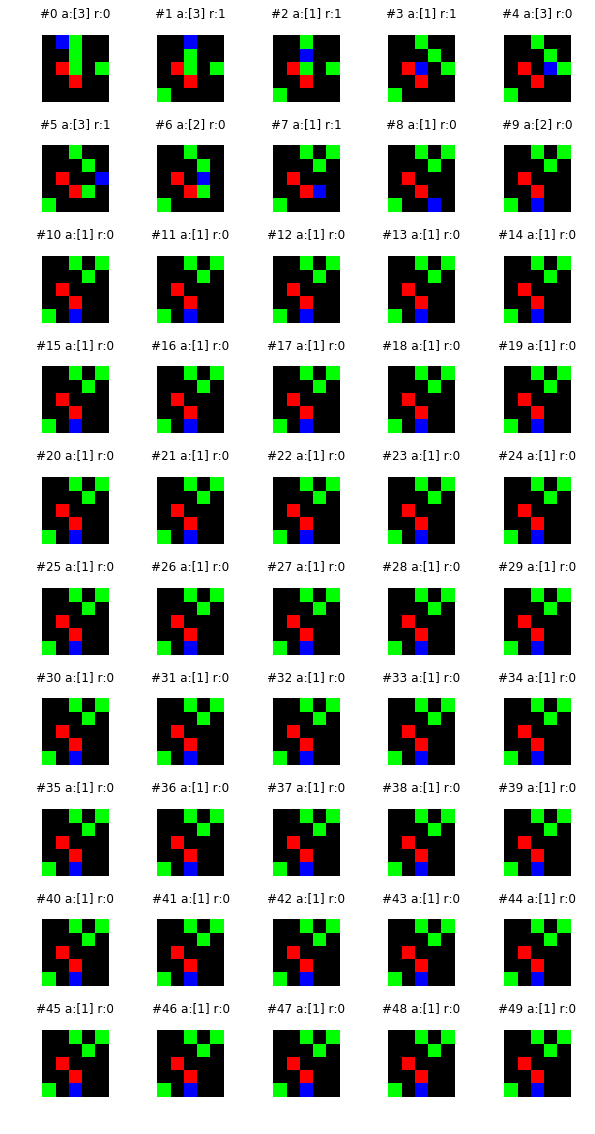

In [17]:
f, axes = plt.subplots(nrows=max_num_step//5, ncols=5, 
                       sharex=True, sharey=True, figsize=(10,20))
done = False
num_step = 0
sum_rewards = 0
state = env.reset()
state = process_state(state)

while not done and num_step < max_num_step:
    action = np.argmax(main_qn.model.predict(np.array([state])),axis=1)
    next_state, reward, done = env.step(action)
    state = process_state(next_state)
    ax = axes.ravel()[num_step]    
    ax.imshow(state)
    ax.set_axis_off()
    ax.set_title("#{} a:{} r:{}".format(num_step, action, int(reward)))
    num_step += 1


In [73]:
model_json = main_qn.model.to_json()

with open("model_keras.json", "w") as output:
    output.write(model_json)